In [1]:
import os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as pth
from PIL.Image import *
from matplotlib import cm
from PIL import Image
import cv2
from PIL import Image
import scipy
from scipy import signal as sg
from scipy import ndimage

np.set_printoptions(precision=2,linewidth=500,suppress=True)

In [2]:
import sys
import os
print(os.path.dirname(sys.executable))

C:\Anaconda


# Image

In [3]:
def multiple_imshow(rows,cols,images ,titles):

    plt.figure(len(images), figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(rows,cols,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        #plt.xticks([]),plt.yticks([]) 
    plt.show()

def defect_detection(path,lower_bound,upper_bound,lower_bound_1 = [0,0,0],upper_bound_1 =[0,0,0]):
    
    img = cv2.imread(path,1)  # BGR color image reading and 0 flag for gray
    
    #blur = cv2.GaussianBlur(img,(5,5),0) #not good results
    #kernel = np.ones((5,5),np.float32)/25 #averaging is not satisfying as well
    #dst = cv2.filter2D(img,-1,kernel)
    #median = cv2.medianBlur(img,5)#median as well
    
    # converting it into Hue, saturation, value (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
   
    '''Threshold'''
    
    # define range of red color in HSV
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    
    # Threshold the HSV image to get only red colors
    mask_0 = cv2.inRange(hsv, lower, upper)
    mask_1 = cv2.inRange(hsv,np.array(lower_bound_1),np.array(upper_bound_1))
    mask =mask_0 + mask_1
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask = mask)
    
    return res


def pre_shaping(image,resol = [284,348]):
    
    #width = resol[1]
    #height = resol[0]
    #dim = (width, height) 
    
    # resize image
    #resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)#INTER_LINEAR_EXACT) 
    
    img = image
    rows,cols = img.shape
    
    frame = [[0,0],[cols,0],[0,rows],[cols,rows]]
    dimension = [[0,0],[resol[1],0],[0,resol[0]],[resol[1],resol[0]]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    resized = cv2.warpPerspective(img,M,(resol[1],resol[0]))
    
    return resized

def real_shaping(normalized_image,rows_dim,cols_dim,i = 8,j = 17):
    
    img = normalized_image
    rows,cols = img.shape
    
    frame = [[i,j],[rows,j],[i,cols],[rows,cols]]
    dimension = [[0,0],[cols_dim,0],[0,rows_dim],[cols_dim,rows_dim]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    real_shape = cv2.warpPerspective(img,M,(cols_dim,rows_dim))
    
    return real_shape

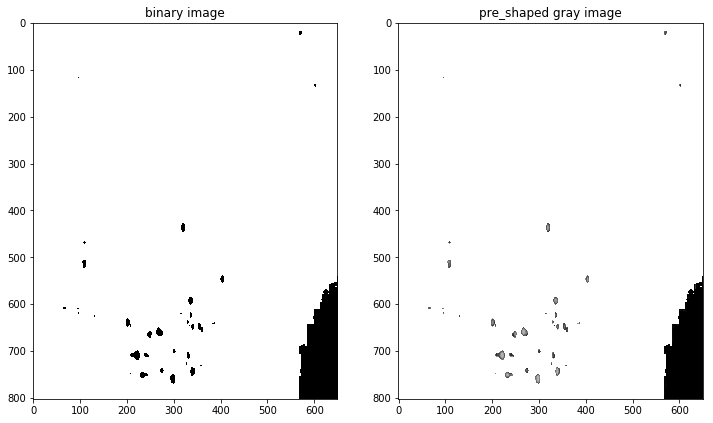

In [10]:
'''Functions call'''

path = "C:/Users/elh/Desktop/xy.png"

''' Big defects : red_yellow'''

lower_bound = [0,0,0]
upper_bound = [55,255,255] # for more defects the upper bound can go till ~105

res = defect_detection(path,lower_bound,upper_bound,[155,0,0],[179,255,255])

"""Binary image to detect the center"""
imgray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY) #convert to gray

#binary thresholding 
ret,thresh = cv2.threshold(imgray,0,1,cv2.THRESH_BINARY)
#th2 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            #cv2.THRESH_BINARY,11,2) #consider some defects as noise


title = 'Global Thresholding (big defects)'

'''shaping'''
#gray image

#img = pre_shaping(img,resol = [350,285])
images = [255-thresh,255-imgray]#255-img]#i,j --> y,x
titles = ['binary image','pre_shaped gray image']

multiple_imshow(1,2,images ,titles)


In [11]:
pre_processed_img = imgray # pre_shaped gray image

## One defect

In [12]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 260, stack, i, j, inComponent)
        
        defect.append((i,j))
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb-1, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]>seuil and not inComponent[i,j]:
                baryAndSizes.append(connected_component_nb(image,seuil,i,j,inComponent))
                
    return baryAndSizes


def step2(image,defect_nb,thresh):
    
    imageR = image
    imageB = image

    baryAndSizesR = all_connected_components(imageR, thresh)
    baryAndSizesB = all_connected_components(imageB, thresh)
    
    xR, xB = np.array([],dtype=int), np.array([],dtype=int)
    yR, yB = np.array([],dtype=int), np.array([],dtype=int)
    sizeR, sizeB = np.array([]), np.array([]) 
    
    for i in range(len(baryAndSizesR)):
        xR = np.append(xR, baryAndSizesR[i][1][0])
        yR = np.append(yR, baryAndSizesR[i][1][1])
        sizeR = np.append(sizeR, baryAndSizesR[i][0])
    
    for i in range(len(baryAndSizesB)):
        xB = np.append(xB, baryAndSizesB[i][1][0])
        yB = np.append(yB, baryAndSizesB[i][1][1])
        sizeB = np.append(sizeB, baryAndSizesB[i][0])
    
    '''plot'''
    fig, ax = plt.subplots(1,3, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,imageR.shape[1])
    ax[1].set_xlim(0,imageB.shape[1])
    ax[2].set_xlim(0,imageB.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(yR, xR, marker='+', s=sizeR, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-imageB, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(yB, xB, marker='o', s=sizeB, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    '''defects list''' 
    #print(baryAndSizesB[0][2])#exemple of defect 0
    test = np.array([],dtype=int)
    test = baryAndSizesB[defect_nb][2] #i.e defect number 10
    test_x = np.ndarray(len(test))
    test_y = np.ndarray(len(test))
    for i in range(len(test)):
        test_x[i] = test[i][1] #x axis
        test_y[i] = test[i][0] #y axis
    
    ax[2].imshow((255-imageR), cmap='gray', vmin = 0, vmax = 255,)
    ax[2].scatter(test_x, test_y, marker='o', s=1, c = 'b', alpha = 0.5)

    test = np.stack((test_x, image.shape[0]-test_y), axis=1)
    
    plt.show()
    
    return yR, image.shape[0]-xR, sizeR,test

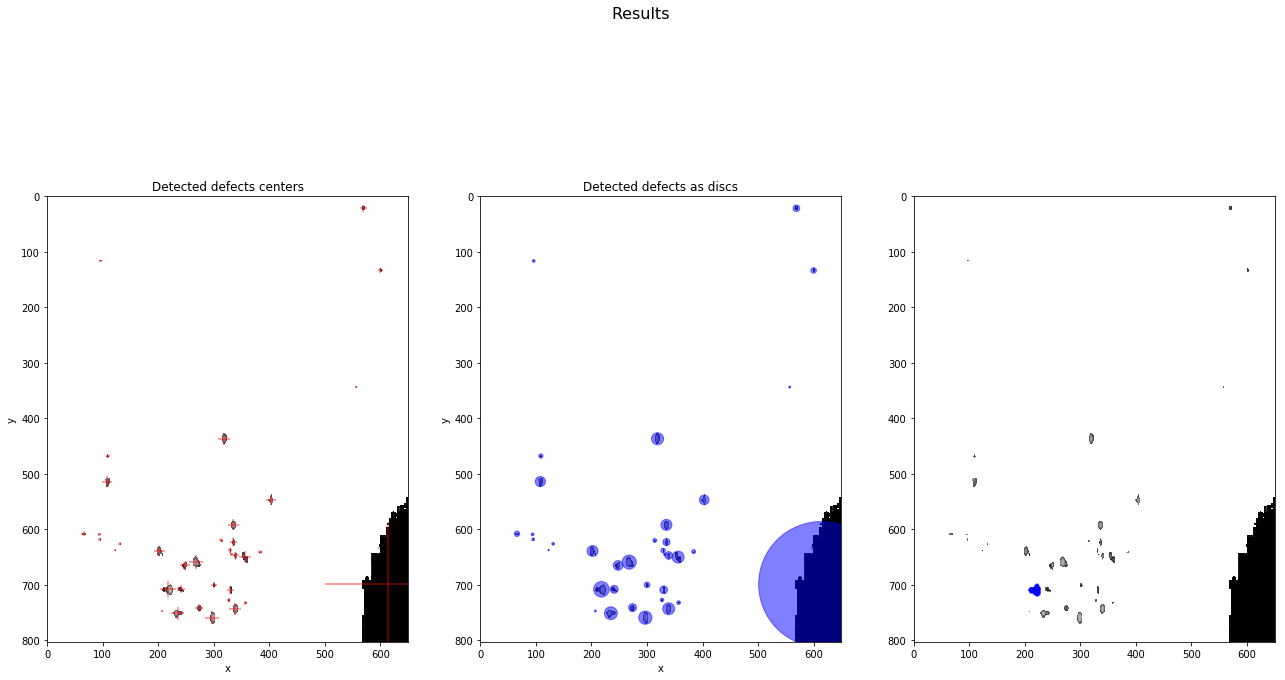

37


In [13]:
'''Call function'''
image = pre_processed_img
#image = cv2.GaussianBlur(imgray,(3,3),0)

x, y,area ,test= step2(image,27,0)#34 no bluring #27 for 50 thresh
xy = np.stack((x, y), axis=1)
print(len(x))

In [8]:
def get_defect_intensity(img,defect): #pixel should np.array (x,y)
    
    defect = np.array(defect,dtype=np.uint64)
    intensity = img[img.shape[0]-defect[:,1],defect[:,0]]
    
    return intensity

In [9]:
defect = np.array(test,dtype=np.uint64)

In [10]:
get_defect_intensity(imgray,defect).size

244

In [11]:
img = image
#img = cv2.GaussianBlur(imgray,(3,3),0)
test.shape,img.shape

((244L, 2L), (803L, 650L))

In [12]:
get_defect_intensity(img,defect).shape

(244L,)

In [13]:
def defect_matrix(img,defect,a,b):
    
    i_min = np.min(img.shape[0]- defect[:,1])#starting line index
    i_max = np.max(img.shape[0]- defect[:,1]+1)#last line index (+1 for python)
    j_min = np.min(defect[:,0])#starting column index
    j_max = np.max(defect[:,0]+1)#last column index (+1 for python)
    
    defect_shape = img[i_min:i_max,j_min:j_max].shape
    dim = np.max(defect_shape)
    case = np.zeros((dim,dim))

    assert (img[i_min:i_max,j_min:j_max][img[i_min:i_max,j_min:j_max]!= 0.].size == get_defect_intensity(img,defect).size)

    case[0:defect_shape[0],0:defect_shape[1]] = img[i_min:i_max,j_min:j_max].copy()
    #case = cv2.GaussianBlur(case,(a,b),0) #smoothing
    
    return case

## Gaussian filter

In [14]:
case_0 = defect_matrix(img,defect,1,1) # original defect
case = defect_matrix(img,defect,9,9) # gaussian

In [15]:
df = pd.DataFrame(case)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,139.0,127.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,176.0,168.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,162.0,168.0,158.0,150.0,160.0,169.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.0,164.0,147.0,131.0,124.0,120.0,163.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,168.0,168.0,143.0,120.0,102.0,97.0,102.0,144.0,162.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181.0,186.0,152.0,116.0,99.0,85.0,76.0,99.0,119.0,167.0,0.0
6,0.0,0.0,151.0,178.0,180.0,131.0,111.0,154.0,192.0,190.0,164.0,125.0,91.0,85.0,83.0,79.0,82.0,101.0,150.0,112.0
7,0.0,0.0,201.0,210.0,207.0,155.0,136.0,191.0,207.0,191.0,156.0,123.0,90.0,78.0,77.0,77.0,75.0,107.0,149.0,149.0
8,132.0,193.0,215.0,215.0,211.0,172.0,148.0,177.0,186.0,171.0,140.0,113.0,87.0,82.0,79.0,75.0,77.0,98.0,138.0,168.0
9,155.0,204.0,212.0,202.0,208.0,186.0,164.0,182.0,186.0,168.0,137.0,110.0,82.0,76.0,79.0,81.0,78.0,93.0,132.0,168.0


## Plot

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def plot_3d(case):
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')


    # Make data.
    X = np.arange(0, case.shape[0], 1)
    Y = np.arange(0, case.shape[0], 1)
    X, Y = np.meshgrid(X, Y)
    Z = (case,case)

    # Plot the surface.
    surf0 = ax0.plot_surface(X, Y, Z[0], cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)


    # Add a color bar which maps values to colors.

    ax1 = fig.add_subplot(1, 2, 2, projection='3d')

    surf1 = ax1.plot_surface( Y, Z[0],X, cmap=cm.coolwarm,
                           linewidth=1, antialiased=True)

    ax0.set_title('Gradient magnitude')
    ax1.set_title('upper perspective')
    plt.savefig('fig')

    plt.show()

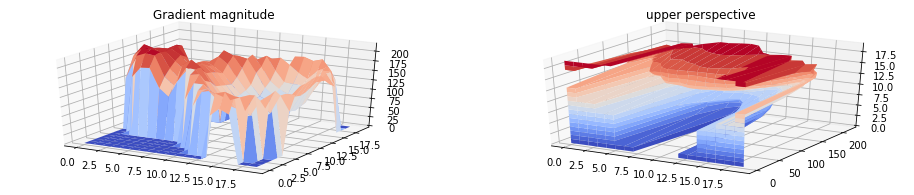

In [17]:
plot_3d(case)

In [18]:
case.shape

(20L, 20L)

# Sobel operator

In [19]:
def getCompassOperators(kind):
    res=np.empty([8,3,3])
    
    if kind=="kirsch":
        conv_mask = np.array([5,  5, 5,-3,-3,-3,-3,-3])
    elif kind=="robinson2":
        conv_mask = np.array([1,2,1,0,-1,-2,-1,0])
    elif kind=="robinson1":
        conv_mask = np.array([1,1,1,0,-1,-1,-1,0])
    
    
    for i in range(8):
        oneDir=np.zeros(9)
        oneDir[[0,1,2,5,8,7,6,3]]=conv_mask
        "to turn the coef"
        conv_mask=np.concatenate([conv_mask[1:],conv_mask[0:1]])
        res[i,:,:]=oneDir.reshape([3,3])
        
    return res

In [20]:
op = getCompassOperators("robinson2")
directions = ["N", "NW", "W", "SW", "S", "SE", "E", "NE"]
for i in range(8):
    print(directions[i])
    print(op[i])

N
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]
NW
[[ 2.  1.  0.]
 [ 1.  0. -1.]
 [ 0. -1. -2.]]
W
[[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]]
SW
[[ 0. -1. -2.]
 [ 1.  0. -1.]
 [ 2.  1.  0.]]
S
[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]
SE
[[-2. -1.  0.]
 [-1.  0.  1.]
 [ 0.  1.  2.]]
E
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
NE
[[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]


We compute the gradients accoring to the 4 possible directions:

In [21]:
operators=getCompassOperators("robinson2")
all_grad = np.abs(np.array([sg.convolve(case, operators[i,:,:], "valid") for i in range(4)]))

### Grad_y

In [22]:
df_grad_y = pd.DataFrame(all_grad[0,:,:])

### Grad_NW

In [23]:
df_grad_NW = pd.DataFrame(all_grad[1,:,:])

### Grad_x

In [24]:
df_grad_x = pd.DataFrame(all_grad[2,:,:])

### Grad_SW

In [25]:
df_grad_SW = pd.DataFrame(all_grad[3,:,:])

In [26]:
"""pour que les dataFrame ne soient pas trop coupées dans la console"""
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 2)

"""
Available options:
display.[chop_threshold, colheader_justify, column_space, date_dayfirst,
         date_yearfirst, encoding, expand_frame_repr, float_format, height,
         line_width, max_columns, max_colwidth, max_info_columns, max_info_rows,
         max_rows, max_seq_items, mpl_style, multi_sparse, notebook_repr_html,
         pprint_nest_depth, precision, width]

""";

### The norm of gradients

In [27]:
 Norm = np.sqrt(all_grad[0,:,:]**2 + all_grad[1,:,:]**2+all_grad[2,:,:]**2+all_grad[3,:,:]**2)

In [28]:
pd.DataFrame(Norm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,298.84,636.30,889.92,963.19,750.43,153.03,741.13,1010.66,413.96
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,624.84,940.88,920.21,613.75,238.74,272.86,214.04,935.31,742.40
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,301.29,652.25,960.98,729.08,57.04,289.81,332.31,323.64,342.66,477.28,994.19
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,682.23,1045.37,818.40,251.44,304.18,346.11,306.04,230.32,328.26,170.07,895.66
4,369.87,736.16,996.32,965.62,822.35,756.48,900.39,1099.91,841.68,109.28,390.97,379.90,259.76,172.28,114.85,269.14,414.37,522.66
5,788.68,1154.92,1206.64,1142.02,1002.65,927.50,1093.82,932.38,371.33,339.20,440.83,302.87,144.34,77.20,56.25,194.09,419.13,224.19
6,1193.45,1010.76,258.26,354.14,451.39,240.08,389.98,52.65,267.68,390.30,382.36,232.56,62.32,32.92,26.94,151.17,400.59,248.37
7,1007.78,550.02,9.59,228.95,370.04,124.84,251.02,112.12,307.94,371.22,343.64,214.71,49.03,13.64,20.74,127.70,370.51,370.29
8,352.96,18.06,64.92,108.94,295.12,117.33,132.46,83.35,275.97,343.00,313.27,188.72,38.88,11.40,16.85,75.51,322.96,452.43
9,257.94,48.87,22.89,57.20,260.67,48.97,75.88,129.85,270.88,329.87,290.82,177.84,32.80,27.24,7.62,39.67,304.36,501.13


### Plot gradient Norm

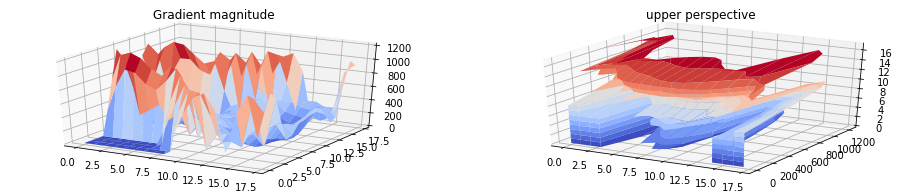

In [29]:
plot_3d(Norm)

# Local minima

In [30]:
""" this function produce a rolling window which is just a view on the data: 
= a special way to move in the data. No copy is made.
"""
def rolling_windows_img(a,kshape):
    outShape=(a.shape[0]-kshape[0]+1,)+(a.shape[1]-kshape[1]+1,)+kshape
    outStrides=a.strides+a.strides
    return np.lib.stride_tricks.as_strided(a,shape=outShape,strides=outStrides)

In [31]:
'''neighbours: [[1,1,1],[1,0,1],[1,1,1]]'''
def findLocalMin(data,kshape,minimum):
    
    dataRoll = rolling_windows_img(data,kshape)
    a,b = dataRoll.shape[0],dataRoll.shape[1]
    L = a*b
    W = kshape[0]*kshape[1]
    dataRoll = dataRoll.reshape(L,W)
    
    if minimum == True:
        armin = np.argmin(dataRoll,axis=1)
    else:
        armin = np.argmax(dataRoll,axis=1)
    
    res=np.array([],dtype=np.int8)
    extrema = 0
    for i, j in enumerate(armin):
        
        where = np.where((dataRoll[i,:] == dataRoll[i,j]))[0]
        
        if (j == W//2 and where.size == 1):
            coord = np.array([i//b + (kshape[0])//2 ,(i%a+ (kshape[1])//2)])
            res = np.append(res, coord)
            extrema +=1
            
    
    res = res.reshape(res.size//2,2)
    
    return res,extrema

In [32]:
matrix = Norm
mini,number_extrema = findLocalMin(matrix,(9,9),True)

### Plot minima

In [33]:
def plot_matrix(matrix,mini,savename):
    points = np.where(matrix !=0.0)
    pts = np.stack((points[1],points[0]),axis =-1)#i,j --> y,x
    plt.plot(pts[:,0],matrix.shape[0]-pts[:,1]-1,"+");
    plt.plot(mini[:,0],matrix.shape[0]-mini[:,1]-1,"o")##i,j --> y,x
    plt.savefig(savename)

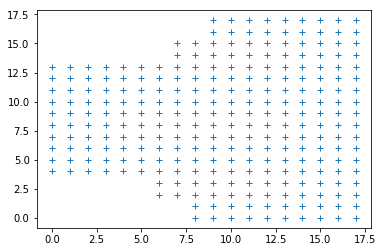

In [34]:
plot_matrix(matrix,mini,'fig minima')


### Kmeans

### Solution 1

In [35]:
from sklearn.cluster import KMeans

In [36]:
points = np.where(case_0 !=0.0)
pts = np.stack((points[1],points[0]),axis =-1)#i,j --> y,x

In [38]:
"""creation of the algo"""
kmeans=KMeans(n_clusters=2)
"""computation of centroids"""
kmeans.fit(pts)
"""here is the result"""
kmeans.cluster_centers_


array([[ 5.96,  9.76],
       [14.8 ,  9.89]])

In [45]:
labels_1 = kmeans.predict(pts)

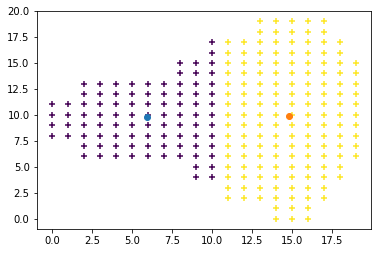

In [41]:
plt.scatter(pts[:,0],pts[:,1],c=labels_1,marker="+");
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")

In [39]:
centroids = kmeans.cluster_centers_

In [40]:
center_1 = centroids[1,:]
center_2 = centroids[0,:]
center_1

array([2.59, 5.41])

### Solution 2

In [41]:
#kmeans.cluster_centers_ = np.fliplr(mini)# np.array([[ 3. , 8.],[15.,  8.]])

In [42]:
#labels = kmeans.predict(pts)
#labels.size == pts[:,1].size

In [43]:
#plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+")
#for centroid in kmeans.cluster_centers_:
    #plt.plot(centroid[0],centroid[1],"o")

In [44]:
#labels

# covariance error ellipse

## sub defect 1

In [45]:
l=pts[:,0]
k=pts[:,1]
a=l[labels_1!=0]
b=k[labels_1!=0]
a.size == b.size

True

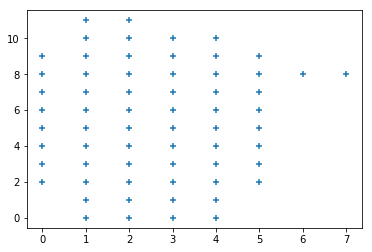

In [46]:
plt.scatter(a,b,marker="+");

In [47]:
ab = np.stack((a,b),axis=0)

In [96]:
cov = np.cov(ab)
cov

array([[3.01, 0.15],
       [0.15, 9.64]])

In [97]:
from numpy import linalg as LA
w, v = LA.eig(cov)
w, v

(array([3.  , 9.65]), array([[-1.  , -0.02],
        [ 0.02, -1.  ]]))

In [106]:
w

array([3.  , 9.65])

In [99]:
index=np.argmax(w)
index

1

In [100]:
a0=center_1[0]#np.mean(a)
b0=center_1[1]#np.mean(b)

In [101]:
angle = np.arctan(v[1,index]/np.abs(v[0,index]))
angle = math.degrees(angle)
angle

-88.69016972611361

In [102]:
sigmax= 2*np.sqrt(4.61*w[0])#length of the ellipse
sigmax_95= 2*np.sqrt(5.991*w[0])#95%
sigmax_80= 2*np.sqrt(3.22*w[0])#80%
sigmay= 2*np.sqrt(4.61*w[1])#width of the ellipse
sigmay_95= 2*np.sqrt(5.99*w[1])#(5.991*w[1])
sigmay_80= 2*np.sqrt(3.22*w[1])

In [103]:
sigmax 

7.442046661885201

## sub defect 2

In [55]:
l1=pts[:,0]
k1=pts[:,1]
a1=l1[labels_1!=1]
b1=k1[labels_1!=1]
a1.size == b1.size

True

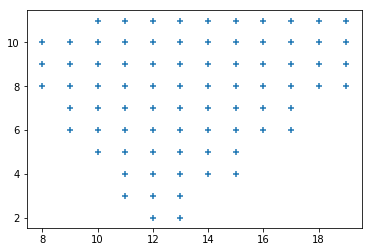

In [104]:
plt.scatter(a1,b1,marker="+");

In [57]:
ab1 = np.stack((a1,b1),axis=0)

In [81]:
cov1 = np.cov(ab1)
cov1

array([[5.92, 1.28],
       [1.28, 8.73]])

In [59]:
from numpy import linalg as LA
w1, v1 = LA.eig(cov1)
w1, v1

(array([5.42, 9.23]), array([[-0.93, -0.36],
        [ 0.36, -0.93]]))

In [73]:
a01=center_2[0]#np.mean(a)
b01=center_2[1]#np.mean(b)#np.mean(a1)


In [74]:
index1=np.argmax(w1)
index1

1

In [75]:
angle1 = np.arctan(v1[1,index1]/np.abs(v1[0,index1]))
angle1 = math.degrees(angle1)
angle1

-68.78690654077037

In [63]:
sigmax1= 2*np.sqrt(4.61*w1[0])#length of the ellipse
sigmax1_95= 2*np.sqrt(5.991*w1[0])#95%
sigmax1_80= 2*np.sqrt(3.22*w1[0])#80%
sigmay1= 2*np.sqrt(4.61*w1[1])#width of the ellipse
sigmay1_95= 2*np.sqrt(5.99*w1[1])#(5.991*w[1])
sigmay1_80= 2*np.sqrt(3.22*w1[1])

In [64]:
sigmax1

9.997163319830468

In [65]:
sigmay1

13.04394001543462

In [66]:
sigmax

7.442046661885201

## Result

In [67]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import math

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


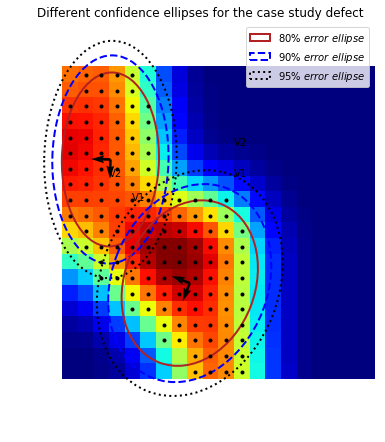

In [68]:
fig = plt.figure(figsize=(16,16))

'''sub defect 1'''

ax = fig.add_subplot(211, aspect='equal')
ax.imshow(case,cmap='jet')
ax.plot(a, b,'.k')

e1_90 = patches.Ellipse((a0, b0), sigmay, sigmax,
                     angle=angle, linewidth=2, fill=False,label=r'$90\%\ error\ ellipse$', edgecolor='blue', linestyle='--')

e1_80 = patches.Ellipse((a0, b0), sigmay_80, sigmax_80,
                     angle=angle, linewidth=2, fill=False,label=r'$80\%\ error\ ellipse$',edgecolor='firebrick')



e1_95 = patches.Ellipse((a0, b0), sigmay_95, sigmax_95,
                     angle=angle, linewidth=2, fill=False,label=r'$95\%\ error\ ellipse$', edgecolor='black', linestyle=':')




ax.add_patch(e1_80)
ax.add_patch(e1_90)
ax.add_patch(e1_95)


'''sub defect 2'''

ax = fig.add_subplot(211, aspect='equal')
ax.plot(a1, b1,'.k')
#ax.fill(a1, b1, alpha=0.2, facecolor='yellow',
        #edgecolor='yellow', linewidth=1, zorder=1)


#index1=1
e2_80 = patches.Ellipse((a01, b01), sigmay1_80, sigmax1_80,
                     angle=angle1, linewidth=2, fill=False, zorder=2,edgecolor='firebrick')

e2_90 = patches.Ellipse((a01, b01), sigmay1, sigmax1,
                     angle=angle1, linewidth=2, fill=False, zorder=2, edgecolor='blue', linestyle='--')

e2_95 = patches.Ellipse((a01, b01), sigmay1_95, sigmax1_95,
                     angle=angle1, linewidth=2, fill=False, zorder=2, edgecolor='black', linestyle=':')



ax.add_patch(e2_90)

ax.add_patch(e2_95)

ax.add_patch(e2_80)



#Plot the eigenvectors
ax.quiver(a0, b0, v[0,1], v[1,1]);
ax.quiver(a0, b0, v[0,0], v[1,0]);
#ax.annotate('Sub defect 1', xy=(-1.,-2))


ax.quiver(a01, b01, v1[0,1], v1[1,1]);
ax.quiver(a01, b01, v1[0,0], v1[1,0]);
ax.annotate('V2', xy=(10.5, 4.5))
ax.annotate('V1', xy=(10.5, 6.5))
ax.annotate('V1', xy=(4, 8))
ax.annotate('V2', xy=(2.5, 6.5))

ax.legend(loc='upper right')


#ax.set_xlim(-7,30)
#ax.set_ylim(-7, 30);

fig.gca().set_aspect('equal', adjustable='box');
ax.axis('off');
ax.set_title('Different confidence ellipses for the case study defect');
fig.savefig('defect 1');

#ax.title('Defect')




# Generalization on all defects

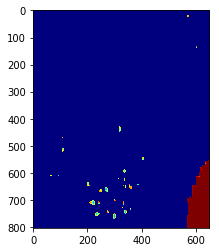

In [69]:
plt.imshow(img,cmap='jet')
plt.show()

# step 1 :Defect detection

In [70]:
def step1(image,thresh,plot):
    
    baryAndSizes = all_connected_components(image, thresh)
    number_of_defects = len(baryAndSizes)
    
    x = np.array([],dtype=float)
    y= np.array([],dtype=float)
    size = np.array([],dtype=np.int8)
    defects = np.array([],dtype=int)
    
     
    '''defects list''' 
    for i in range(number_of_defects):#baryAndSizes = nb, barycentre,defect
        x = np.append(x, baryAndSizes[i][1][0])
        y = np.append(y, baryAndSizes[i][1][1])
        size = np.append(size, baryAndSizes[i][0])
        defects = np.append(defects, baryAndSizes[i][2])
        
    
   
    '''plot'''
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (22,12))
        fig.suptitle('Results', fontsize=16)
        ax[0].set_xlim(0,image.shape[1])
        ax[1].set_xlim(0,image.shape[1])
        ax[2].set_xlim(0,image.shape[1])

        title = ['Detected defects centers','Detected defects as discs']
        ax[0].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
        ax[0].scatter(y, x, marker='+', s=size, c = 'r', alpha = 0.5)
        ax[0].set_title(title[0])

        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')

        ax[1].imshow(255-image, cmap='gray', vmin = 0, vmax = 255,)
        ax[1].scatter(y, x, marker='o', s=size, c = 'b', alpha = 0.5)
        ax[1].set_title(title[1])

        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        fig.show()
    

    return y, image.shape[0]-x, size,defects #return the cooordinates in x,y axis

In [71]:
%%time
x, y, size,alldefects = step1(imgray,0,False)

Wall time: 1.68 s


# Step 2: defects area,centers and coordinates

In [72]:
a =[[1,2],[4,6]]
np.fliplr(a)

array([[2, 1],
       [6, 4]])

## Convert (x,y) <--> (i,j)

In [74]:
def xy_ij(xy_coord,dim_y):
    
    xy_coord = np.array(xy_coord)
    
    ij_coord = np.fliplr(xy_coord)
    ij_coord[:,0] =  dim_y - ij_coord[:,0]
    
    return ij_coord

def ij_xy(ij_coord,dim_y):
    
    ij_coord = np.array(ij_coord)
    
    ij_coord[:,0] =  dim_y - ij_coord[:,0]
    xy_coord = np.fliplr(ij_coord)
    
    return xy_coord
    

In [75]:

"""pour que les dataFrame ne soient pas trop coupées dans la console"""
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

"""
Available options:
display.[chop_threshold, colheader_justify, column_space, date_dayfirst,
         date_yearfirst, encoding, expand_frame_repr, float_format, height,
         line_width, max_columns, max_colwidth, max_info_columns, max_info_rows,
         max_rows, max_seq_items, mpl_style, multi_sparse, notebook_repr_html,
         pprint_nest_depth, precision, width]

""";

In [76]:
def get_defect_intensity(img,defect): #pixel should np.array (x,y)
    
    defect = np.array(defect)
    #defect = xy_ij(defect,img.shape[0])
    i = defect[:,0] 
    j = defect[:,1]
    intensity = img[i.astype(int),j.astype(int)]
    
    return intensity

In [77]:
def clean_defects(pandasoutput,lines_to_delete):
    
    output = pandasoutput.drop(lines_to_delete)
    
    return output
    

In [219]:
def defects_output(img,x, y, size,alldefect,upper_intensity):
    
    alldefect = alldefects.reshape((alldefect.size//2,2))#i,j
    
    #defects = ij_xy(alldefect,img.shape[0])
    alldefect = alldefect.tolist()
    centers = np.stack((x, y), axis=-1)
    mean_intensity = []
    
    output = pd.DataFrame([[],[], [],[]]).T
                          #columns = ['Centers', 'Area', 'the ith defect (x,y) coordinates'])
    drop=[]
    for i,j in enumerate(size):
        ieme_defect = pd.DataFrame(alldefect[0:j])
        Intensity = get_defect_intensity(img,ieme_defect)
        mean_intensity = np.mean(Intensity)
        if mean_intensity > upper_intensity:
            drop.append(i)
 
        ith_line = pd.DataFrame([[centers[i,:].round(2), size[i],mean_intensity.round(2),ieme_defect]],index = np.array([i]))
        output = output.append(ith_line)
        alldefect = alldefect[j:]


    output.columns = ['Centers in (x,y)', 'Area','Average intensity', 'the ith defect in (i,j)'] 
    assert(np.array_equal(np.array([output['the ith defect in (i,j)'][i].size//2 for i in range(37)]),size))
    
    output['Area']=output['Area'].astype(int)
    
    #output = clean_defects(output,drop)

    return output #i,j

In [220]:
output = defects_output(img,x, y, size,alldefects,215)
output

,"Centers in (x,y)",Area,Average intensity,"the ith defect in (i,j)"
0,"[569, 781]",46,174.35,0 1 0 19 567 1 19 568 2 19 56...
1,"[96, 686]",8,148.75,0 1 0 117 95 1 117 96 2 117 97 3 ...
2,"[600, 669]",32,172.16,0 1 0 131 599 1 131 600 2 131...
3,"[557, 459]",4,162.75,0 1 0 344 557 1 344 558 2 345 55...
4,"[319, 366]",148,146.46,0 1 0 428 317 1 428 318 2 ...
5,"[109, 335]",18,163.67,0 1 0 466 109 1 466 110 2 467...
6,"[108, 289]",104,149.49,0 1 0 508 106 1 508 107 2 ...
7,"[403, 256]",94,141.86,0 1 0 538 403 1 538 404 2 539...
8,"[614, 104]",15761,254.54,0 1 0 542 647 1 542 64...
9,"[335, 211]",122,139.51,0 1 0 586 333 1 586 334 2 ...


# Step 3: Sub-defects

## Matrix of each defect

In [221]:
def defect_matrix(img,defect,a,b):
    
    defect = np.array(defect)
    
    i_min = np.min(defect[:,0])#starting line index
    i_max = np.max(defect[:,0]+1)#last line index (+1 for python)
    j_min = np.min(defect[:,1])#starting column index
    j_max = np.max(defect[:,1]+1)#last column index (+1 for python)
    
    defect_shape = img[i_min:i_max,j_min:j_max].shape
    dim = np.max(defect_shape)
    matrix = np.zeros((dim,dim))

    assert (img[i_min:i_max,j_min:j_max][img[i_min:i_max,j_min:j_max]!= 0.].size == get_defect_intensity(img,defect).size)

    matrix[0:defect_shape[0],0:defect_shape[1]] = img[i_min:i_max,j_min:j_max].copy()
    matrix = cv2.GaussianBlur(matrix,(a,b),0) #smoothing
    
    return matrix

In [250]:
defect = 1

print np.array(output['the ith defect in (i,j)'][defect]).shape

matrix = defect_matrix(img,output['the ith defect in (i,j)'][defect],9,9)
pd.DataFrame(matrix)

(8L, 2L)


,0,1,2,3
0,97.058356,97.100934,96.962379,96.818605
1,86.786790,86.835403,86.732296,86.614278
2,65.607047,65.658208,65.608684,65.533880
3,55.403048,55.457027,55.436451,55.384056


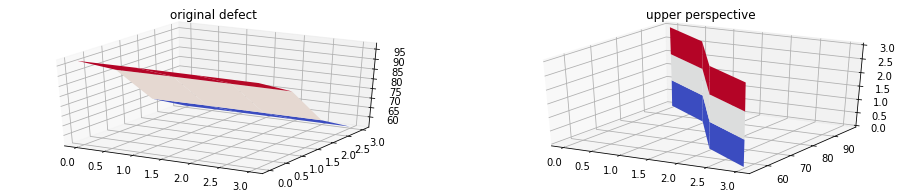

In [251]:
plot_3d(matrix)

## Gradient of the defect

In [252]:
operators=getCompassOperators("robinson2")
all_grad = np.abs(np.array([sg.convolve(matrix, operators[i,:,:], "valid") for i in range(4)]))

In [253]:
Norm = np.sqrt(all_grad[0,:,:]**2 + all_grad[1,:,:]**2+all_grad[2,:,:]**2+all_grad[3,:,:]**2)

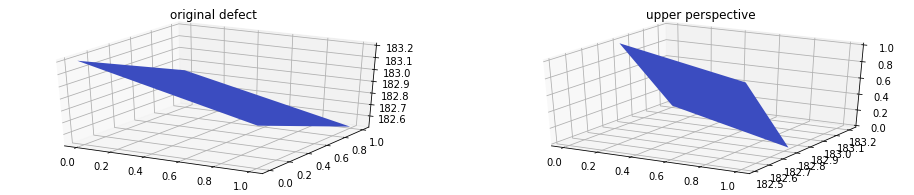

In [254]:
plot_3d(Norm)

## Extrema of the defect

In [255]:
def extrema_number(local_window_dim,Mat):
    kshape = min(local_window_dim,Mat.shape[0])

    if kshape%2 == 0:
        kshape = kshape -1

    mini,number_extrema = findLocalMin(Norm,(kshape,kshape),True)
    print number_extrema
    
    return mini 

In [256]:
extrema_number(9,Norm)

4


array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]], dtype=int64)

## Separation

In [229]:
from sklearn.cluster import KMeans

In [230]:
case = output['the ith defect in (i,j)'][defect]
case

,0,1
0,637,123
1,638,123


In [231]:
points = np.array(case)
pts = ij_xy(points,img.shape[0])


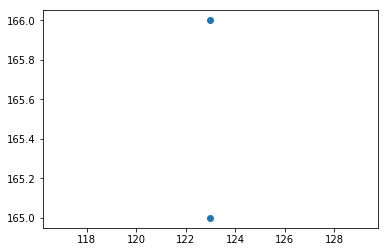

In [232]:
plt.plot(pts[:,0],pts[:,1],"o");

In [233]:
"""creation of the algo"""
kmeans=KMeans(n_clusters=2)
"""computation of centroids"""
kmeans.fit(pts)
"""here is the result"""
kmeans.cluster_centers_


array([[123., 165.],
       [123., 166.]])

In [234]:
labels = kmeans.predict(pts)

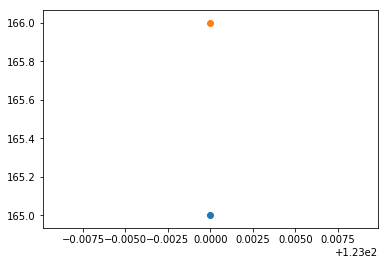

In [235]:
plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+");
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")

In [236]:
centroids = kmeans.cluster_centers_

In [237]:
centroids #x,y

array([[123., 165.],
       [123., 166.]])

In [238]:
def separation(case,number_extrema):
    
    points = np.array(case)#i,j
    pts = ij_xy(points,img.shape[0])
    
    '''
    plt.plot(pts[:,0],pts[:,1],"o");
    '''
    
    """creation of the algo"""
    kmeans=KMeans(n_clusters=number_extrema)
    """computation of centroids"""
    kmeans.fit(pts)
    """here is the result"""
    centroids = kmeans.cluster_centers_
    labels = kmeans.predict(pts)
    
    '''
    plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+");
    for centroid in centroids:
        plt.plot(centroid[0],centroid[1],"o")
    '''
    
    assertion = 0
    sub_defects = []
    for i in range(number_extrema):
        sub_defects.append(pts[labels == i])#x,y replace with points if i,j
        assertion += sub_defects[i].size//2
        
    assert (assertion == points.size//2)
        
    return centroids,sub_defects #x,y
    

In [239]:
case = output['the ith defect in (i,j)'][27]

In [240]:
k,o = separation(case,2)

In [241]:
case1 = output['the ith defect in (i,j)'][34]

In [242]:
k1,o1 = separation(case1,2)

In [243]:
case2 = output['the ith defect in (i,j)'][21]

In [244]:
k2,o2 = separation(case2,2)

# Plot all sub defects

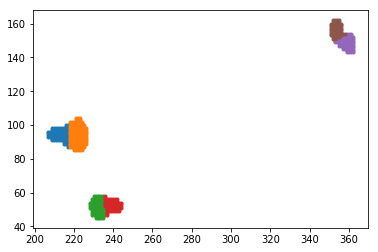

In [245]:
plt.plot(o[0][:,0],o[0][:,1],".");
plt.plot(o[1][:,0],o[1][:,1],".");

plt.plot(o1[0][:,0],o1[0][:,1],".");
plt.plot(o1[1][:,0],o1[1][:,1],".");

plt.plot(o2[0][:,0],o2[0][:,1],".");
plt.plot(o2[1][:,0],o2[1][:,1],".");
